# 06 - CNN models

In this notebook, we are going to do CNN models (We are going to do also with transfer Learning).

(Also gonna work with a sample of our dataset to be able to evaluate faster the results.
Our sample is gonna be equalized/normalize by the classes, equal amount for each class)

We are gonna do:
   - build an NN;
   - build with different pre-models;
      - VGG16;
      - VGG19;
      - Resnet (working with 3 channels);
Evaluate the results with: Accuracy, Precision, Recall and f1


### Steps: 
 - Importing/accessing the data
 - Separeting the Train and Test Data
 - Fitting the models 
 - Evaluate the model
    - Accuracy, Precision, Recall, f1  .....  Confusion Matrix 
 - Using the model to predict the specifics images

## Importing/accessing the data

First, importing the libs and treating the data:

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_directory = '../datasets/dataset_normal/'

# Load and preprocess images
def load_images(directory):
    images = []
    labels = []
    for label, folder in enumerate(os.listdir(directory)):
        for filename in os.listdir(os.path.join(directory, folder)):
            img = cv2.imread(os.path.join(directory, folder, filename))
            img = cv2.resize(img, (100, 100))  # Resize image
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            images.append(img.flatten())  # Flatten image
            labels.append(label)
    return np.array(images), np.array(labels)

# Feature extraction
images, labels = load_images(dataset_directory)

# Feature scaling (optional but recommended)
images = images / 255.0  # Scale pixel values to range [0, 1]


In [2]:
# Sanity Check
images.shape
# labels

(17092, 30000)

## Separeting the Train and Test Data

Spliting data into training and testing sets

In [3]:
# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.6, test_size=0.2, stratify=labels, random_state=42)


In [4]:
print(X_train.shape)
print(y_train.shape)
# print(y_train)
print(X_test.shape)
print(y_train.shape)

(10255, 30000)
(10255,)
(3419, 30000)
(10255,)


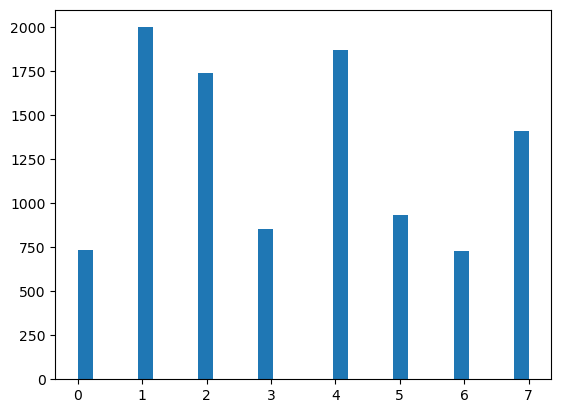

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train, bins=30)
plt.show()

In [6]:
from sklearn.utils import resample

# Calculate the size of the smallest class
min_class_size = min(np.bincount(y_train))

# Undersampling majority classes to match the size of the minority class
X_train_balanced = []
y_train_balanced = []
for i in range(8):  # Assuming you have 8 classes
    X_class_i = X_train[y_train == i]
    y_class_i = y_train[y_train == i]
    X_class_i_resampled, y_class_i_resampled = resample(X_class_i, y_class_i, n_samples=min_class_size, random_state=42)
    X_train_balanced.append(X_class_i_resampled)
    y_train_balanced.append(y_class_i_resampled)

X_train_balanced = np.concatenate(X_train_balanced)
y_train_balanced = np.concatenate(y_train_balanced)

# #-------------------------
# # Oversampling minority classes to match the size of the majority class
# # You can use techniques like SMOTE for better synthetic sampling
# # Here, I'm just duplicating existing samples
# X_train_balanced_oversampled = []
# y_train_balanced_oversampled = []
# for i in range(8):  # Assuming you have 8 classes
#     X_class_i = X_train[y_train == i]
#     y_class_i = y_train[y_train == i]
#     X_class_i_oversampled, y_class_i_oversampled = resample(X_class_i, y_class_i, n_samples=len(X_train_balanced), random_state=42)
#     X_train_balanced_oversampled.append(X_class_i_oversampled)
#     y_train_balanced_oversampled.append(y_class_i_oversampled)

# X_train_balanced_oversampled = np.concatenate(X_train_balanced_oversampled)
# y_train_balanced_oversampled = np.concatenate(y_train_balanced_oversampled)


In [7]:
print(X_train_balanced.shape)
print(y_train_balanced.shape)
# print(y_train)


(5824, 30000)
(5824,)


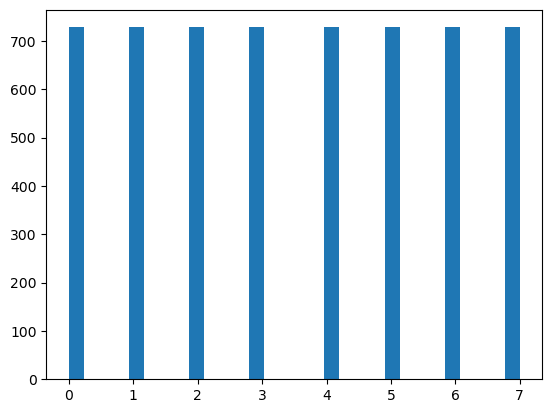

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_train_balanced, bins=30)
plt.show()

## Training the model (train the logistic regression)

Training/fiting the models

### Resnet-50

In [9]:
#import the base model -> resnet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.applications import ResNet50V2

res_model = ResNet50V2(
    # weights='imagenet',
    include_top=False,
    input_shape=(100,100,3)
)
res_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['conv1_conv[0][0]']    

In [10]:
# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [11]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow import keras


x = res_model.output
x = Flatten()(x) 
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
output = Dense(8, activation='softmax')(x)

#---------------

model = Model(inputs=res_model.input, 
              outputs=output)

#---------------


# set_random_seed(121)
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)


In [12]:
from tensorflow.keras.utils import to_categorical

# Reshape flattened input data back to images
X_train_images = X_train_balanced.reshape(-1, 100, 100, 3)
X_test_images = X_test.reshape(-1, 100, 100, 3)

# y_train_balanced contains your target labels
# Converting target labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_balanced, num_classes=8)
y_test_encoded = to_categorical(y_test, num_classes=8)


history = model.fit(
    X_train_images,
    y_train_encoded,
          epochs=10,
    validation_data=(X_test_images, y_test_encoded),
          # callbacks=[early_stop]
         )

2024-04-10 15:12:50.600613: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
182/182 [==============================] - 53s 286ms/step - loss: 1.7116 - accuracy: 0.3489 - val_loss: 1.4741 - val_accuracy: 0.4618
Epoch 2/10
182/182 [==============================] - 53s 293ms/step - loss: 1.0125 - accuracy: 0.6262 - val_loss: 0.9569 - val_accuracy: 0.6587
Epoch 3/10
182/182 [==============================] - 54s 297ms/step - loss: 0.5585 - accuracy: 0.8139 - val_loss: 0.8070 - val_accuracy: 0.7286
Epoch 4/10
182/182 [==============================] - 52s 286ms/step - loss: 0.3615 - accuracy: 0.8853 - val_loss: 0.8710 - val_accuracy: 0.7289
Epoch 5/10
182/182 [==============================] - 51s 283ms/step - loss: 0.2377 - accuracy: 0.9317 - val_loss: 0.8122 - val_accuracy: 0.7432
Epoch 6/10
182/182 [==============================] - 52s 286ms/step - loss: 0.1565 - accuracy: 0.9562 - val_loss: 0.8740 - val_accuracy: 0.7426
Epoch 7/10
182/182 [==============================] - 52s 285ms/step - loss: 0.0984 - accuracy: 0.9775 - val_loss: 0.8305 - val_ac

In [13]:
# Evaluate the model's performance on the test data
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 20s 184ms/step - loss: 0.9848 - accuracy: 0.7789
Test loss: 0.9848375916481018
Test accuracy: 0.7788827419281006


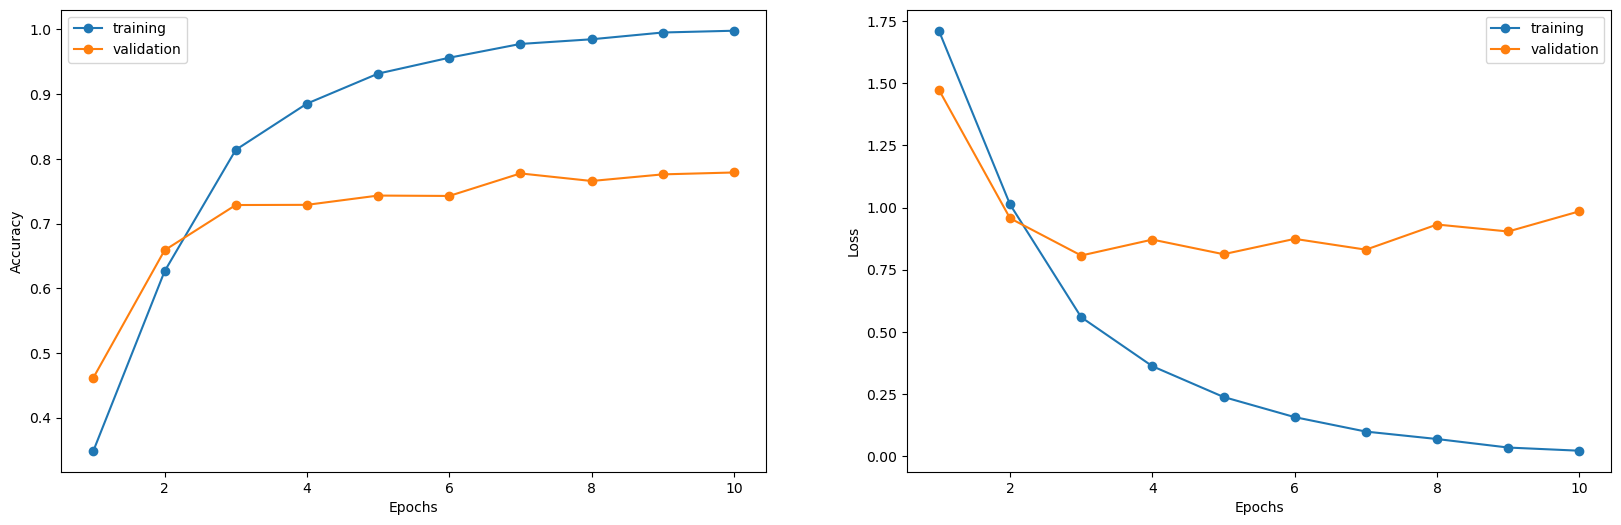

In [23]:
epochs = range(1, 11)

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluete the model

Seeing how the model peform with the train and test data:

In [42]:
# # Training and test score
# print(f"Train score: {validated_logreg.score(X_train_balanced, y_train_balanced)}")
# print(f"Test score: {validated_logreg.score(X_test, y_test)}")

Train score: 0.8475274725274725
Test score: 0.6653992395437263


### Accuracy, Precision, Recall, f1

Getting Accuracy, Precision, Recall and f1 from the model and seeing in each class

In [48]:
# Evaluate the model's performance on the test data
# Accuracy
score = model.evaluate(X_test_images, y_test_encoded, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

107/107 [==============================] - 19s 179ms/step - loss: 0.9848 - accuracy: 0.7789
Test loss: 0.9848375916481018
Test accuracy: 0.7788827419281006


In [53]:
# Evaluating the model
y_pred = model.predict(X_test_images)
y_pred
# accuracy = accuracy_score(y_test_encoded, y_pred)
# print("Accuracy:", accuracy)


array([[3.8101259e-03, 5.6765126e-10, 9.9045438e-01, ..., 6.7900948e-15,
        2.7953767e-10, 5.1344921e-23],
       [6.4488703e-10, 9.7276443e-01, 2.1371547e-07, ..., 1.4698182e-04,
        9.2225513e-05, 4.8317799e-09],
       [2.6411208e-13, 9.8484904e-01, 9.7791903e-13, ..., 1.4832888e-02,
        1.7290257e-06, 3.0818282e-04],
       ...,
       [1.1651693e-12, 4.4148721e-02, 8.3377934e-15, ..., 9.5555305e-01,
        1.5325583e-06, 2.9505216e-04],
       [3.4367022e-07, 9.2701554e-01, 7.2648390e-06, ..., 3.8172003e-02,
        1.4374281e-04, 1.5380184e-06],
       [4.3356062e-16, 9.9951971e-01, 7.6913531e-11, ..., 2.4105003e-04,
        2.0325657e-12, 2.9552873e-05]], dtype=float32)

In [58]:
np.argmax(y_pred[0])

2

In [70]:
# Predicting
predict_probas = model.predict(X_test_images)

# ONE-HOT ENCODE
# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)
# Convert one-hot encoded labels(y_test) to class labels
y_test_labels = np.argmax(y_test_encoded, axis=1)

# Evaluating the model
accuracy = accuracy_score(y_test_labels, y_predict)
print("Accuracy:", accuracy)


Accuracy: 0.778882714243931


In [74]:
from sklearn.metrics import classification_report

# # Convert one-hot encoded labels to class labels for y_test
# y_test_labels = np.argmax(y_test_encoded, axis=1)

# Generate classification report
report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)


              precision    recall  f1-score   support

           0       0.61      0.77      0.68       243
           1       0.80      0.83      0.81       666
           2       0.77      0.60      0.67       579
           3       0.73      0.65      0.69       284
           4       0.74      0.82      0.78       624
           5       0.78      0.80      0.79       310
           6       0.76      0.81      0.79       243
           7       0.96      0.94      0.95       470

    accuracy                           0.78      3419
   macro avg       0.77      0.78      0.77      3419
weighted avg       0.78      0.78      0.78      3419



### Confusion Matrix 

Plotting the confusion Matrix (as a porcentage) and observate the classification from the model

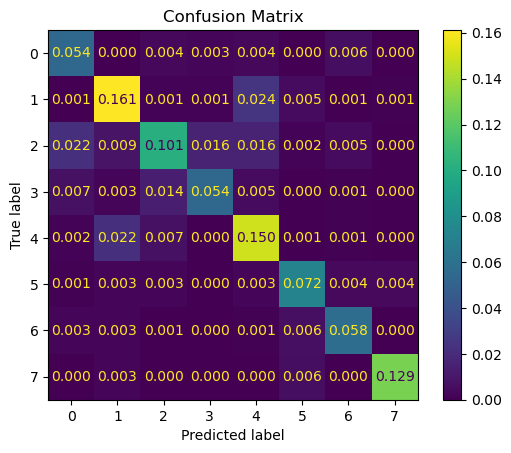

In [152]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_labels, y_predict, normalize='all', values_format='.3f')
plt.title('Confusion Matrix')
plt.show()


In [89]:
from sklearn.preprocessing import LabelBinarizer

# use a LabelBinarizer to binarize the target by one-hot-encoding in a OvR fashion.
# This means that the target of shape (n_samples,) is mapped to a target of shape (n_samples, n_classes).

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

# #check the encoding of a specific class: #SanityCheck
# label_binarizer.transform([1])

(3419, 8)

In [92]:
cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize lists to store fpr, tpr, and auc for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(8):
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(8):
    plt.plot(all_fpr[i], all_tpr[i], label=f"Class {i} (AUC = {all_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc="lower right")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

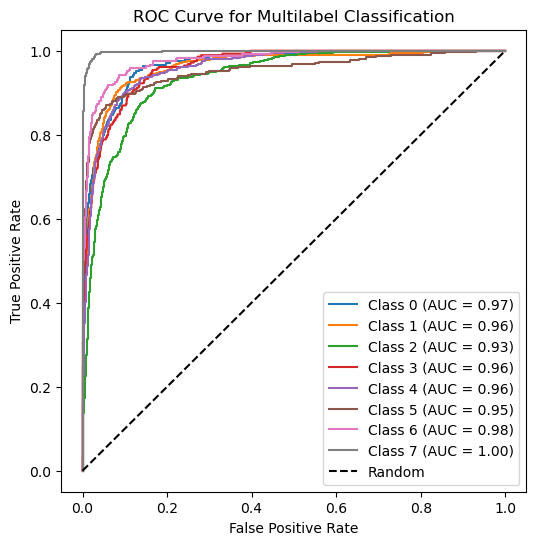

In [111]:
# Calculate the predictions
y_score = model.predict(X_test_images)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Initialize lists to store fpr, tpr, and auc for each class
all_fpr = []
all_tpr = []
all_auc = []

# Compute ROC curve and AUC for each class
for i in range(8):
    fpr, tpr, _ = roc_curve(y_test_encoded[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curve for each class
# plt.figure(figsize=(10, 7))
plt.figure(figsize=(6, 6))
for i in range(8):
    plt.plot(all_fpr[i], all_tpr[i], label=f"Class {i} (AUC = {all_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend(loc="lower right")
plt.show()


In [113]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

# ---------------------
# Can also evaluate with the build-in method, but for the next plot we need to have the variables

# micro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="micro",
# )

# print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")


Micro-averaged One-vs-Rest ROC AUC score:
0.97


In [114]:
# ROC curve using the OvR macro-average

n_classes = 8
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

# ---------------------
# Can also evaluate with the build-in method, but for the next plot we need to have the variables
# macro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="macro",
# )
# print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")


Macro-averaged One-vs-Rest ROC AUC score:
0.96


NOTE : In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demoed here.

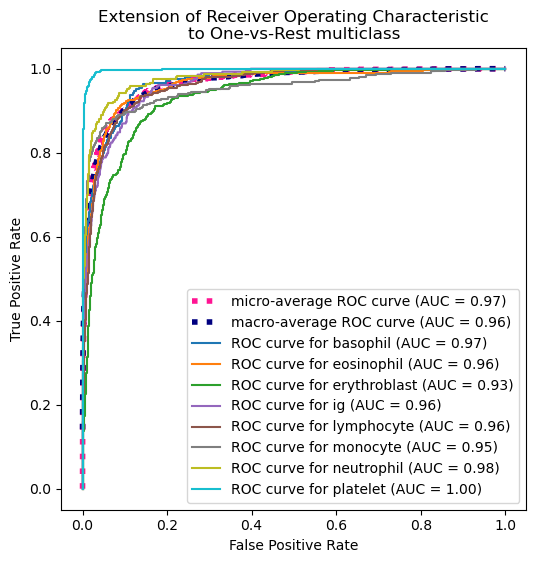

In [115]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

#Plotting micro-avg Roc curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plotting Macro-AVG Roc curve
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Classes numbers
n_classes = 8

# Generate a color palette
colors = cycle(plt.cm.tab10(np.linspace(0, 1, n_classes)))

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {cells[class_id]}",
        color=color,
        ax=ax,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

#reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

## Using the model to predict the specifics images

In [ ]:
# Load the model 

# logreg = joblib.load('../models/logistic_regression_model.pkl')
# result = logreg.score(X_test, y_test)
# print(result)

In [56]:
filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'

cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

img = cv2.imread(os.path.join(filename))
img = cv2.resize(img, (100, 100))  # Resize image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
X = img.flatten()  # Flatten image
X = X / 255.0  

result = logreg.predict([X])
print(f"The cell that was detect was: {cells[result[0]]}")

The cell that was detect was: basophil


In [151]:
# filename = '../datasets/dataset_normal/basophil/BA_47.jpg'
# filename = '../datasets/dataset_normal/neutrophil/BNE_715.jpg'
filename = '../datasets/dataset_normal/neutrophil/BNE_840.jpg'

cells = {
    0 : 'basophil',
    1 : 'eosinophil',
    2 : 'erythroblast',
    3 : 'ig',
    4 : 'lymphocyte',
    5 : 'monocyte',
    6 : 'neutrophil',
    7 : 'platelet',
}

img = cv2.imread(os.path.join(filename))
# # img = cv2.resize(img, (100, 100))  # Resize image
# # # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
# # # X = img.flatten()  # Flatten image
# # X = X / 255.0  

# # image = img.resize((80, 80))
# # image = np.array(img, dtype = 'float32')
# img =X / 255
# image = img.reshape(1, 100, 100, 3)
#   # prediction = model.predict(image)





# img = cv2.imread(os.path.join(directory, folder, filename))
img = cv2.resize(img, (100, 100))  # Resize image
images = img.flatten()  # Flatten image





# result = model.predict([X])
result = model.predict(image)
# print(result)
print(np.argmax(result))
# print(cells[np.argmax(result)])

# print(f"The cell that was detect was: {cells[result[0]]}")

5
